In [1]:
!pip install --quiet transformers
!pip install --quiet lightning
!pip install --quiet accelerate
!pip install --quiet bitsandbytes
!pip install --quiet peft

In [2]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
from pathlib import Path
from typing import List, Dict
import tqdm.notebook as tq
from tqdm.notebook import tqdm
import json

import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import lightning as L
from lightning.pytorch.callbacks import ModelCheckpoint, LearningRateMonitor 
from sklearn.model_selection import train_test_split
from transformers import (
    T5ForConditionalGeneration,
    T5TokenizerFast as T5Tokenizer,
    Adafactor
)
from torch.optim.lr_scheduler import LambdaLR, ReduceLROnPlateau
from datasets import load_dataset

import spacy
from nltk.tokenize import word_tokenize

nlp = spacy.load("en_core_web_sm")

In [3]:
from peft.peft_model import PeftModel
from peft.config import PeftConfig
from peft.mapping import get_peft_model
from peft.tuners import LoraConfig
from peft.utils import TaskType
from peft import prepare_model_for_kbit_training
from transformers import BitsAndBytesConfig
from transformers import AutoModelForSeq2SeqLM

In [4]:
L.seed_everything(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

INFO: Seed set to 42


device(type='cuda')

In [5]:
dataset = load_dataset('lmqg/qg_squad')

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset qg_squad downloaded and prepared to /root/.cache/huggingface/datasets/lmqg___qg_squad/qg_squad/5.0.1/9e98299f104904c043a5679c3f2464c57fca6cd2b371c0169c8abfd9b3f161a1. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [6]:
raw_train_df = dataset['train'].to_pandas()
raw_val_df = dataset['validation'].to_pandas()
raw_test_df = dataset['test'].to_pandas()

In [7]:
def get_start_indices(row):
    paragraph = row['paragraph_answer']
    sentence = row['sentence_answer']
    
    para_start_idx = paragraph.index('<hl>') if '<hl>' in paragraph else -1
    sent_start_idx = sentence.index('<hl>') if '<hl>' in sentence else -1

    return para_start_idx, sent_start_idx


tqdm.pandas()
raw_train_df[['para_answer_start', 'sent_answer_start']] = \
    raw_train_df.progress_apply(get_start_indices, axis=1, result_type="expand")
raw_val_df[['para_answer_start', 'sent_answer_start']] = \
    raw_val_df.progress_apply(get_start_indices, axis=1, result_type="expand")
raw_test_df[['para_answer_start', 'sent_answer_start']] = \
    raw_test_df.progress_apply(get_start_indices, axis=1, result_type="expand")

  0%|          | 0/75722 [00:00<?, ?it/s]

  0%|          | 0/10570 [00:00<?, ?it/s]

  0%|          | 0/11877 [00:00<?, ?it/s]

In [8]:
use_cols = ['answer', 'question', 'sentence', 'paragraph', 'para_answer_start', 'sent_answer_start']
squad_train_df = raw_train_df[use_cols]
squad_dev_df = raw_val_df[use_cols]
squad_test_df = raw_test_df[use_cols]

In [9]:
def generate_tokens(df):
    tokens_data = []
    for index, row in tqdm(df.iterrows(), total=df.shape[0]):
        context = str(row['paragraph'])
        context_sent = str(row['sentence'])
        question = str(row['question'])
        answer = str(row['answer'])
        
        context_len = len(context)
        
        # Tokenize context, question, and answer
        context_tokens = context.split()
        question_tokens = question.split()
        answer_tokens = answer.split()
        
        num_tokens_context = len(context_tokens)
        
        # Calculate ratios and round to 3 decimal places
        lqc = round(len(question_tokens) / num_tokens_context, 3)
        lac = round(len(answer_tokens) / num_tokens_context, 3)
        coqc = round(len(set(question_tokens) & set(context_tokens)) / num_tokens_context, 3)
        coac = round(len(set(answer_tokens) & set(context_tokens)) / num_tokens_context, 3)
        
        # Calculate positions and round to 3 decimal places
        sa = round(row['para_answer_start'] / context_len, 3)
        se = round((row['para_answer_start'] + len(answer)) / context_len, 3)
        mpos = round((sa + se) / 2, 3)
        
        lac_tokens = len(answer_tokens)
        coac_tokens = len(set(answer_tokens) & set(context_tokens))
        pos_characters = (row['para_answer_start'] + row['para_answer_start'] + len(answer)) // 2
        lqc_tokens = len(question_tokens)
        coqc_tokens = len(set(question_tokens) & set(context_tokens))
        
        instruction = (
            f"The context has {context_len} characters and {num_tokens_context} tokens. "
            f"LAC is {lac} so the answer has around {lac_tokens} tokens because {lac} * {num_tokens_context} = {round(lac * num_tokens_context, 3)}. "
            f"COAC is {coac} so the answer uses about {coac_tokens} tokens from the context because {coac} * {num_tokens_context} = {round(coac * num_tokens_context, 3)}. "
            f"POS is {mpos} so the answer is located approximately at character {pos_characters} because {mpos} * {context_len} = {round(mpos * context_len, 3)}. "
            f"LQC is {lqc} so the question has around {lqc_tokens} tokens because {lqc} * {num_tokens_context} = {round(lqc * num_tokens_context, 3)}. "
            f"COQC is {coqc} so the question uses about {coqc_tokens} tokens from the context because {coqc} * {num_tokens_context} = {round(coqc * num_tokens_context, 3)}. "
            f"To conclude, the satisfied information can be used in the context is '{context_sent}'."
        )
        
        # Append the calculated tokens
        tokens_data.append({
            'LQC': lqc,
            'LAC': lac,
            'COQC': coqc,
            'COAC': coac,
            'MPOS': mpos,
            'instruction': instruction
        })
        
    return pd.DataFrame(tokens_data)

In [10]:
train_tokens = generate_tokens(squad_train_df)
dev_tokens = generate_tokens(squad_dev_df)
test_tokens = generate_tokens(squad_test_df)

  0%|          | 0/75722 [00:00<?, ?it/s]

  0%|          | 0/10570 [00:00<?, ?it/s]

  0%|          | 0/11877 [00:00<?, ?it/s]

In [11]:
# Merge tokens with original datasets
squad_train_df = pd.concat([squad_train_df, train_tokens], axis=1)
squad_dev_df = pd.concat([squad_dev_df, dev_tokens], axis=1)
squad_test_df = pd.concat([squad_test_df, test_tokens], axis=1)

In [12]:
squad_train_df.head(2)

,answer,question,sentence,paragraph,para_answer_start,sent_answer_start,LQC,LAC,COQC,COAC,MPOS,instruction
0,established beliefs or customs,What is heresy mainly at odds with?,Heresy is any provocative belief or theory tha...,Heresy is any provocative belief or theory tha...,77,77,0.121,0.069,0.034,0.052,0.255,The context has 362 characters and 58 tokens. ...
1,A heretic,What is a person called is practicing heresy?,A heretic is a proponent of such claims or bel...,Heresy is any provocative belief or theory tha...,109,0,0.138,0.034,0.034,0.034,0.314,The context has 362 characters and 58 tokens. ...


In [13]:
squad_train_df.describe()

,para_answer_start,sent_answer_start,LQC,LAC,COQC,COAC,MPOS
count,75722.000000,75722.000000,75722.000000,75722.000000,75722.000000,75722.000000,75722.000000
mean,313.924645,76.862920,0.096938,0.030481,0.046729,0.025735,0.434849
std,262.664196,71.438744,0.060498,0.034964,0.033798,0.031803,0.297036
min,0.000000,0.000000,0.004000,0.002000,0.000000,0.000000,0.001000
25%,106.000000,26.000000,0.060000,0.010000,0.025000,0.008000,0.169000
50%,256.000000,60.000000,0.083000,0.019000,0.040000,0.016000,0.395000
75%,463.000000,109.000000,0.116000,0.035000,0.059000,0.031000,0.682000
max,3126.000000,2161.000000,0.935000,0.650000,0.657000,0.593000,0.998000


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

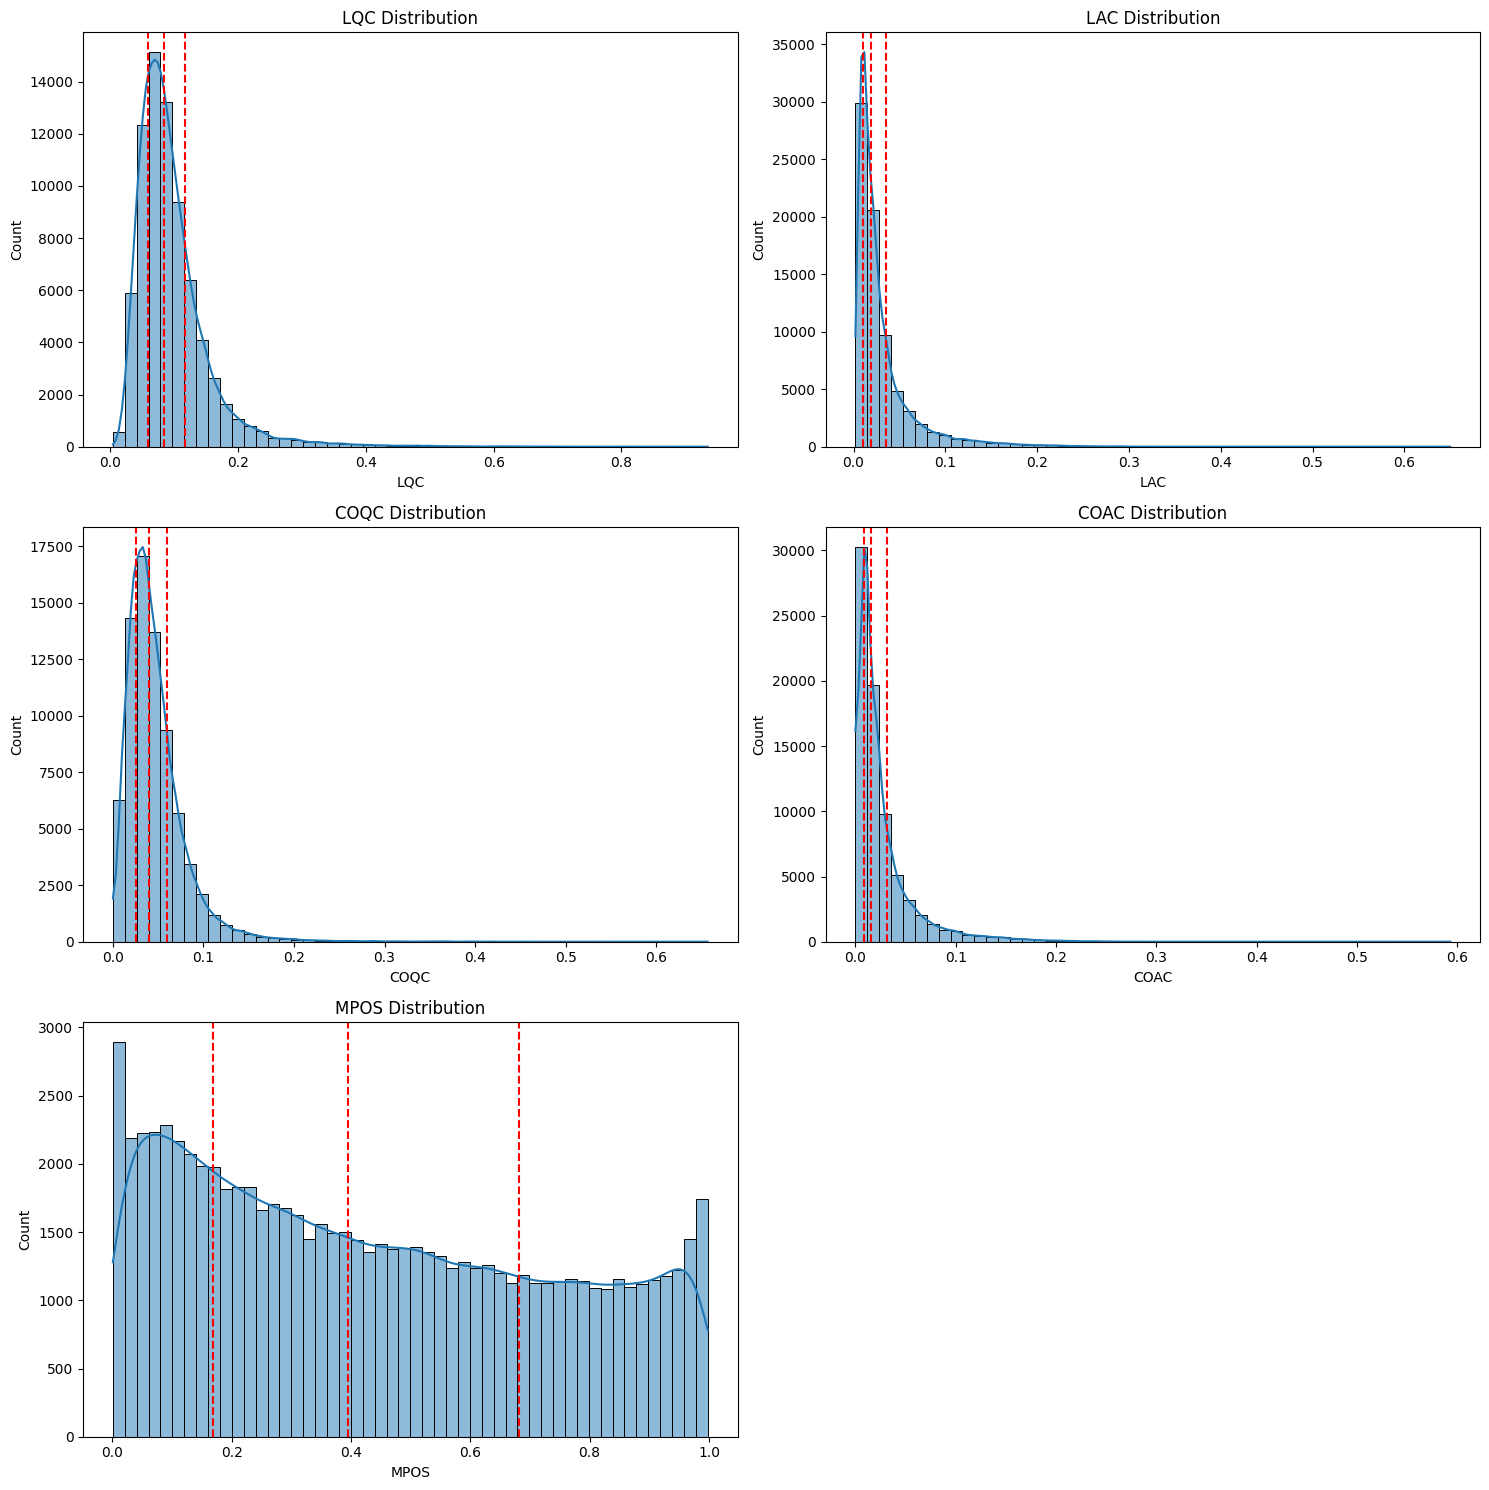

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = squad_train_df.copy()

fig, axs = plt.subplots(3, 2, figsize=(15, 15))

sns.histplot(df['LQC'], bins=50, kde=True, ax=axs[0, 0])
axs[0, 0].axvline(x=0.059603, color='r', linestyle='--') # 25%
axs[0, 0].axvline(x=0.083333, color='r', linestyle='--') # 50%
axs[0, 0].axvline(x=0.116279, color='r', linestyle='--') # 75%
axs[0, 0].set_title('LQC Distribution')

sns.histplot(df['LAC'], bins=50, kde=True, ax=axs[0, 1])
axs[0, 1].axvline(x=0.010417, color='r', linestyle='--') # 25%
axs[0, 1].axvline(x=0.019048, color='r', linestyle='--') # 50%
axs[0, 1].axvline(x=0.035088, color='r', linestyle='--') # 75%
axs[0, 1].set_title('LAC Distribution')

sns.histplot(df['COQC'], bins=50, kde=True, ax=axs[1, 0])
axs[1, 0].axvline(x=0.025157, color='r', linestyle='--') # 25%
axs[1, 0].axvline(x=0.039604, color='r', linestyle='--') # 50%
axs[1, 0].axvline(x=0.059211, color='r', linestyle='--') # 75%
axs[1, 0].set_title('COQC Distribution')

sns.histplot(df['COAC'], bins=50, kde=True, ax=axs[1, 1])
axs[1, 1].axvline(x=0.008197, color='r', linestyle='--') # 25%
axs[1, 1].axvline(x=0.015625, color='r', linestyle='--') # 50%
axs[1, 1].axvline(x=0.031250, color='r', linestyle='--') # 75%
axs[1, 1].set_title('COAC Distribution')

sns.histplot(df['MPOS'], bins=50, kde=True, ax=axs[2, 0])
axs[2, 0].axvline(x=0.168977, color='r', linestyle='--') # 25%
axs[2, 0].axvline(x=0.394949, color='r', linestyle='--') # 50%
axs[2, 0].axvline(x=0.682288, color='r', linestyle='--') # 75%
axs[2, 0].set_title('MPOS Distribution')

fig.delaxes(axs[2, 1])

plt.tight_layout()
plt.show()

In [15]:
def filter_dataset(df):
    lqc_upper_threshold = 0.2
    lqc_lower_threshold = 0
    lac_upper_threshold = 0.1
    lac_lower_threshold = 0
    coqc_upper_threshold = 0.1
    coqc_lower_threshold = 0
    coac_upper_threshold = 0.1
    coac_lower_threshold = 0

    # Identify rows to be removed based on the criteria
    remove_indices = df[
        (df['LQC'] > lqc_upper_threshold) | (df['LQC'] < lqc_lower_threshold) |
        (df['LAC'] > lac_upper_threshold) | (df['LAC'] < lac_lower_threshold) |
        (df['COQC'] > coqc_upper_threshold) | (df['COQC'] < coqc_lower_threshold) |
        (df['COAC'] > coac_upper_threshold) | (df['COAC'] < coac_lower_threshold)
    ].index

    percentage_removed = (len(remove_indices) / len(df)) * 100

    return remove_indices, percentage_removed

removed_indices, percent_removed = filter_dataset(squad_train_df)
print(f"Removed {len(removed_indices)} rows, which is {percent_removed:.2f}% of the dataset.")

Removed 8697 rows, which is 11.49% of the dataset.


In [16]:
squad_train_df = squad_train_df.drop(removed_indices)

In [17]:
squad_train_df = squad_train_df.reset_index(drop=True)
squad_dev_df = squad_dev_df.reset_index(drop=True)
squad_test_df = squad_test_df.reset_index(drop=True)

In [18]:
squad_train_df.head(2)

,answer,question,sentence,paragraph,para_answer_start,sent_answer_start,LQC,LAC,COQC,COAC,MPOS,instruction
0,established beliefs or customs,What is heresy mainly at odds with?,Heresy is any provocative belief or theory tha...,Heresy is any provocative belief or theory tha...,77,77,0.121,0.069,0.034,0.052,0.255,The context has 362 characters and 58 tokens. ...
1,A heretic,What is a person called is practicing heresy?,A heretic is a proponent of such claims or bel...,Heresy is any provocative belief or theory tha...,109,0,0.138,0.034,0.034,0.034,0.314,The context has 362 characters and 58 tokens. ...


In [19]:
MODEL_NAME = 't5-small'

In [20]:
tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)
print('tokenizer len: ', len(tokenizer))
TOKENIZER_LEN = len(tokenizer)

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

tokenizer len:  32100


In [21]:
def get_exceeding_indices(df, tokenizer, max_length):
    exceeding_indices = []
    for idx, row in tqdm(df.iterrows(), total=df.shape[0]):
        instruction = row['instruction']
        tokens = tokenizer.tokenize(instruction)
        token_length = len(tokens)
        
        if token_length > max_length:
            exceeding_indices.append(idx)
    
    return exceeding_indices

limit_length = 256

exceeding_train_indices = get_exceeding_indices(squad_train_df, tokenizer, limit_length)
exceeding_dev_indices = get_exceeding_indices(squad_dev_df, tokenizer, limit_length)
exceeding_test_indices = get_exceeding_indices(squad_test_df, tokenizer, limit_length)
print(len(exceeding_train_indices), len(exceeding_train_indices)/len(squad_train_df) * 100)
print(len(exceeding_dev_indices), len(exceeding_dev_indices)/len(squad_dev_df) * 100)
print(len(exceeding_test_indices), len(exceeding_test_indices)/len(squad_test_df) * 100)

  0%|          | 0/67025 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (517 > 512). Running this sequence through the model will result in indexing errors


  0%|          | 0/10570 [00:00<?, ?it/s]

  0%|          | 0/11877 [00:00<?, ?it/s]

2046 3.0525923162998883
434 4.105960264900662
296 2.4922118380062304


In [22]:
# Remove rows with exceeding indices
squad_train_df = squad_train_df.drop(exceeding_train_indices).reset_index(drop=True)
squad_dev_df = squad_dev_df.drop(exceeding_dev_indices).reset_index(drop=True)
squad_test_df = squad_test_df.drop(exceeding_test_indices).reset_index(drop=True)

In [23]:
SOURCE_MAX_TOKEN_LEN = 512
TARGET_MAX_TOKEN_LEN = 256

SEP_TOKEN = '</s>'

In [24]:
squad_train_df.to_csv("squad_train.csv", index=False)
squad_dev_df.to_csv("squad_dev.csv", index=False)
squad_test_df.to_csv("squad_test.csv", index=False)

In [25]:
squad_train_df.head()

,answer,question,sentence,paragraph,para_answer_start,sent_answer_start,LQC,LAC,COQC,COAC,MPOS,instruction
0,established beliefs or customs,What is heresy mainly at odds with?,Heresy is any provocative belief or theory tha...,Heresy is any provocative belief or theory tha...,77,77,0.121,0.069,0.034,0.052,0.255,The context has 362 characters and 58 tokens. ...
1,A heretic,What is a person called is practicing heresy?,A heretic is a proponent of such claims or bel...,Heresy is any provocative belief or theory tha...,109,0,0.138,0.034,0.034,0.034,0.314,The context has 362 characters and 58 tokens. ...
2,Greek,What language does the term heresy find its ro...,The term heresy is from Greek αἵρεσις original...,The term heresy is from Greek αἵρεσις original...,24,24,0.105,0.011,0.032,0.011,0.046,The context has 574 characters and 95 tokens. ...
3,slightly different,What is the relationship between the context h...,"The word ""heresy"" is usually used within a Chr...",The term heresy is from Greek αἵρεσις original...,355,94,0.179,0.021,0.095,0.021,0.634,The context has 574 characters and 95 tokens. ...
4,heresiarch,What is the head person of a heretical movemen...,The founder or leader of a heretical movement ...,The term heresy is from Greek αἵρεσις original...,450,58,0.105,0.011,0.074,0.000,0.792,The context has 574 characters and 95 tokens. ...


In [26]:
import random

class QGDataset(Dataset):

    def __init__(
        self,
        data: pd.DataFrame,
        tokenizer: T5Tokenizer,
        source_max_token_len: int,
        target_max_token_len: int
        ):

        self.tokenizer = tokenizer
        self.data = data
        self.source_max_token_len = source_max_token_len
        self.target_max_token_len = target_max_token_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index: int):
        data_row = self.data.iloc[index]

        answer = data_row['answer']
        sentence = data_row['sentence']
        paragraph = data_row['paragraph']
        question = data_row['question']
        
        lqc = data_row['LQC']
        lac = data_row['LAC']
        coqc = data_row['COQC']
        coac = data_row['COAC']
        mpos = data_row['MPOS']
        instruction = data_row['instruction']
        
        # Randomly select a task
        task_choice = random.choices(['qg', 'qa', 'tu'], weights=[0.4, 0.3, 0.3])[0]
        
        masking_proba = 0.25
        if task_choice == 'qg':
            task_prefix = "Question generation: "
            control_qg = f"LQC {lqc} LAC {lac} COQC {coqc} COAC {coac} POS {mpos}"
            input_text = f"{task_prefix} {control_qg} {SEP_TOKEN} {paragraph}"
            target_text = f"{question}; {answer} {SEP_TOKEN}"
        elif task_choice == 'qa':
            task_prefix = "Question answering: "
            control_qa = f"LAC {lac} COAC {coac}"
            if random.random() < masking_proba:
                control_qa = ""
            input_text = f"{task_prefix} {control_qa} {SEP_TOKEN} {paragraph} {SEP_TOKEN} {question}"
            target_text = f"{answer} {SEP_TOKEN}"
        else:
            task_prefix = "Token understanding: "
            control_tu = f"LQC {lqc} LAC {lac} COQC {coqc} COAC {coac} POS {mpos}"
            input_text = f"{task_prefix} {control_tu} {SEP_TOKEN} {paragraph}"
            target_text = f"{instruction} {SEP_TOKEN}"

        source_encoding = self.tokenizer(
            input_text,
            max_length=self.source_max_token_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            add_special_tokens=True,
            return_tensors='pt'
        )
    
        target_encoding = tokenizer(
            target_text,
            max_length=self.target_max_token_len,
            padding='max_length',
            truncation = True,
            return_attention_mask=True,
            add_special_tokens=True,
            return_tensors='pt'
            )
        
        labels = target_encoding['input_ids']  
        labels[labels == 0] = -100
        
        return dict(
            input_ids = source_encoding['input_ids'].flatten(),
            attention_mask = source_encoding['attention_mask'].flatten(),
            labels=labels.flatten(),
            )

In [27]:
class QGDataModule(L.LightningDataModule):

    def __init__(
        self,
        train_df: pd.DataFrame,
        val_df: pd.DataFrame,
        test_df: pd.DataFrame,
        tokenizer: T5Tokenizer,
        batch_size,
        source_max_token_len: int,
        target_max_token_len: int
        ): 
        super().__init__()
        self.batch_size = batch_size
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        self.tokenizer = tokenizer
        self.source_max_token_len = source_max_token_len
        self.target_max_token_len = target_max_token_len

    def setup(self, stage=None):
        self.train_dataset = QGDataset(self.train_df, self.tokenizer, self.source_max_token_len, self.target_max_token_len)
        self.val_dataset = QGDataset(self.val_df, self.tokenizer, self.source_max_token_len, self.target_max_token_len)
        self.test_dataset = QGDataset(self.test_df, self.tokenizer, self.source_max_token_len, self.target_max_token_len)

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size = self.batch_size, shuffle=True, num_workers = 2)

    def val_dataloader(self): 
        return DataLoader(self.val_dataset, batch_size=1, num_workers=2)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=1, num_workers=2)

In [28]:
N_EPOCHS = 10
BATCH_SIZE = 16
LEARNING_RATE = 0.001

In [29]:
DF_TAKE_PERCENTAGE = 1

TAKE_TRAIN = int(len(squad_train_df) * DF_TAKE_PERCENTAGE)
TAKE_DEV = int(len(squad_dev_df) * DF_TAKE_PERCENTAGE)
TAKE_TEST = int(len(squad_test_df) * DF_TAKE_PERCENTAGE)

print('Taking', DF_TAKE_PERCENTAGE * 100, '%')
print(TAKE_TRAIN, 'of', len(squad_train_df))
print(TAKE_DEV, 'of', len(squad_dev_df))
print(TAKE_TEST, 'of', len(squad_test_df))

Taking 100 %
64979 of 64979
10136 of 10136
11581 of 11581


In [30]:
print(squad_train_df[:TAKE_TRAIN].shape, squad_dev_df[:TAKE_DEV].shape, squad_test_df[:TAKE_TEST].shape)

data_module = QGDataModule(squad_train_df[:TAKE_TRAIN], squad_dev_df[:TAKE_DEV], squad_test_df[:TAKE_TEST], tokenizer, BATCH_SIZE, SOURCE_MAX_TOKEN_LEN, TARGET_MAX_TOKEN_LEN)
data_module.setup()

(64979, 12) (10136, 12) (11581, 12)


In [31]:
bnb_config=BitsAndBytesConfig(
    load_in_8bit=True
)

peft_config=LoraConfig(
    task_type=TaskType.SEQ_2_SEQ_LM,
    r=32, # dimension of the low-rank matrices
    lora_alpha=8, # the scaling factor for the low-rank matrices
    lora_dropout=0.001, # the dropout probability of the LoRA layers
    target_modules="all-linear",
)

In [32]:
class QGModel(L.LightningModule):
    def __init__(self, model_name=None, peft_config=None, bnb_config=None):
        super().__init__()
        if model_name is None:
            model_name = 't5-small'
        if bnb_config is None:
            bnb_config=BitsAndBytesConfig(
                load_in_8bit=True
            )
        if peft_config is None:
            peft_config=LoraConfig(
                task_type=TaskType.SEQ_2_SEQ_LM,
                r=32, # dimension of the low-rank matrices
                lora_alpha=8, # the scaling factor for the low-rank matrices
                lora_dropout=0.001, # the dropout probability of the LoRA layers
                target_modules="all-linear",
            )
        self.model_name = model_name
        self.peft_config = peft_config
        self.bnb_config = bnb_config
        self.peft_model = None
        self.initialize_model()

    def initialize_model(self):
        model = T5ForConditionalGeneration.from_pretrained(
            self.model_name,
            quantization_config=self.bnb_config,
            return_dict=True
        )
        model = prepare_model_for_kbit_training(model)
        self.peft_model = get_peft_model(model, self.peft_config)

    def load_peft_model(self, peft_path):
        t5model = T5ForConditionalGeneration.from_pretrained(
            self.model_name,
            quantization_config=self.bnb_config,
            return_dict=True
        )
        t5model = prepare_model_for_kbit_training(t5model)
        self.peft_model = PeftModel.from_pretrained(t5model, peft_path, is_trainable=True)
        
    def forward(self, input_ids, attention_mask, labels=None):
        output = self.peft_model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        return output.loss, output.logits

    def training_step(self, batch, batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['labels']
        loss, output = self(input_ids, attention_mask, labels) 
        self.log('train_loss', loss, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['labels']
        loss, output = self(input_ids, attention_mask, labels) 
        self.log('val_loss', loss, prog_bar=True, logger=True)
        return loss

    def test_step(self, batch, batch_idx):
        input_ids = batch['input_ids']
        attention_mask = batch['attention_mask']
        labels = batch['labels']
        loss, output = self(input_ids, attention_mask, labels) 
        self.log('test_loss', loss, prog_bar=True, logger=True)
        return loss

    def configure_optimizers(self):
        optimizer = Adafactor(self.parameters(), 
                          scale_parameter=False, 
                          relative_step=False, 
                          warmup_init=False, lr=LEARNING_RATE)
        
        def lr_lambda(epoch):
            if epoch < 4:
                return 1.0  # No change in LR for the first 3 epochs
            else:
                return 0.95 ** (epoch - 2)  # Reduce LR by a factor of 0.95 from epoch 4 onwards
        
        scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)
        return [optimizer], [{'scheduler': scheduler, 'interval': 'epoch', 'frequency': 1}]

In [33]:
checkpoint_callback = ModelCheckpoint(
    dirpath='checkpoints',
    filename='best-checkpoint-qg',
    save_top_k=-1,
    verbose=True,
    monitor='val_loss',
    mode='min'
)

lr_monitor = LearningRateMonitor(logging_interval='epoch')

In [34]:
trainer = L.Trainer(
    callbacks=[checkpoint_callback, lr_monitor],
    max_epochs=N_EPOCHS,
    log_every_n_steps=30
)

INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs


In [35]:
model = QGModel(MODEL_NAME, peft_config, bnb_config)
peft_path = '/kaggle/input/lorat5-answer-aware-finetuned'
if os.path.exists(peft_path):
    model.load_peft_model(peft_path)
    model.peft_model.to(device)
    model.peft_model.print_trainable_parameters()
    print(f"Load checkpoint file successfully!")
else:
    model.initialize_model()
    print(f"The checkpoint file at {peft_path} does not exist, initialize model")

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

The checkpoint file at /kaggle/input/lorat5-answer-aware-finetuned does not exist, initialize model


In [36]:
trainer.fit(model, data_module)

2024-06-19 07:02:42.839704: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-19 07:02:42.839829: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-19 07:02:42.982155: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO: 
  | Name       | Type                  | Params | Mode 
-------------------------------------------------------------
0 | peft_model | PeftModelForSeq2SeqLM | 64.8 M | train
-------------------------------------------------------------
4.3 M     Trainable params
60.5 M    Non-trainable params
64.8 M    Total 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/bitsandbytes/autograd/_functions.py:316: UserWarning: MatMul8bitLt: inputs will be cast from torch.float32 to float16 during quantization
  warnings.warn(f"MatMul8bitLt: inputs will be cast from {A.dtype} to float16 during quantization")


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 0, global step 4062: 'val_loss' reached 0.78767 (best 0.78767), saving model to '/kaggle/working/checkpoints/best-checkpoint-qg.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 1, global step 8124: 'val_loss' reached 0.74191 (best 0.74191), saving model to '/kaggle/working/checkpoints/best-checkpoint-qg-v1.ckpt' as top 2


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 2, global step 12186: 'val_loss' reached 0.71915 (best 0.71915), saving model to '/kaggle/working/checkpoints/best-checkpoint-qg-v2.ckpt' as top 3


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 3, global step 16248: 'val_loss' reached 0.69352 (best 0.69352), saving model to '/kaggle/working/checkpoints/best-checkpoint-qg-v3.ckpt' as top 4


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 4, global step 20310: 'val_loss' reached 0.70242 (best 0.69352), saving model to '/kaggle/working/checkpoints/best-checkpoint-qg-v4.ckpt' as top 5


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 5, global step 24372: 'val_loss' reached 0.65784 (best 0.65784), saving model to '/kaggle/working/checkpoints/best-checkpoint-qg-v5.ckpt' as top 6


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 6, global step 28434: 'val_loss' reached 0.66103 (best 0.65784), saving model to '/kaggle/working/checkpoints/best-checkpoint-qg-v6.ckpt' as top 7


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 7, global step 32496: 'val_loss' reached 0.64475 (best 0.64475), saving model to '/kaggle/working/checkpoints/best-checkpoint-qg-v7.ckpt' as top 8


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 8, global step 36558: 'val_loss' reached 0.66119 (best 0.64475), saving model to '/kaggle/working/checkpoints/best-checkpoint-qg-v8.ckpt' as top 9


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Epoch 9, global step 40620: 'val_loss' reached 0.65783 (best 0.64475), saving model to '/kaggle/working/checkpoints/best-checkpoint-qg-v9.ckpt' as top 10
INFO: `Trainer.fit` stopped: `max_epochs=10` reached.


In [37]:
# Save adapter
for file_name in os.listdir('checkpoints'):
    model_path = 'checkpoints/' + file_name
    print("==> Save adapter ", model_path)
    test_model = QGModel.load_from_checkpoint(model_path)
    peft_path = 'pefts/' + file_name
    test_model.peft_model.save_pretrained(peft_path)

==> Save adapter  checkpoints/best-checkpoint-qg-v3.ckpt
==> Save adapter  checkpoints/best-checkpoint-qg-v1.ckpt
==> Save adapter  checkpoints/best-checkpoint-qg-v9.ckpt
==> Save adapter  checkpoints/best-checkpoint-qg.ckpt
==> Save adapter  checkpoints/best-checkpoint-qg-v8.ckpt
==> Save adapter  checkpoints/best-checkpoint-qg-v7.ckpt
==> Save adapter  checkpoints/best-checkpoint-qg-v6.ckpt
==> Save adapter  checkpoints/best-checkpoint-qg-v4.ckpt
==> Save adapter  checkpoints/best-checkpoint-qg-v2.ckpt
==> Save adapter  checkpoints/best-checkpoint-qg-v5.ckpt


In [38]:
import shutil

shutil.make_archive('archive_shutil', format='zip', root_dir='pefts')

'/kaggle/working/archive_shutil.zip'

In [39]:
def generate(qgmodel, context) -> str:
    lqc = 0.02
    lac = 0.02
    coqc = 0.02
    coac = 0.02
    for mpos in (0.1, 0.3, 0.5, 0.7, 0.9):

        task_prefix = "Question generation: "
        control_qg = "LQC {lqc} LAC {lac} COQC {coqc} COAC {coac} POS {mpos} SC {sc} QR {qr}"
        input_text = f"{task_prefix} {control_qg} {SEP_TOKEN} {context}"

        source_encoding = tokenizer(
            input_text,
            max_length=SOURCE_MAX_TOKEN_LEN,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            add_special_tokens=True,
            return_tensors='pt'
        )

        generated_ids = qgmodel.generate(
            input_ids=source_encoding['input_ids'].to(device),
            attention_mask=source_encoding['attention_mask'].to(device),
            num_beams=10,
#             top_p=0.95,
#             do_sample=True,
            max_length=TARGET_MAX_TOKEN_LEN,
            early_stopping=True,
            use_cache=True
        )

        preds = {
            tokenizer.decode(generated_id, skip_special_tokens=False, clean_up_tokenization_spaces=True)
            for generated_id in generated_ids
        }
        print(''.join(preds))

context = '''
It was interesting that the model trained on our dataset outperformed humans on the Feeling dimension.
This was likely because the answers to these Feeling questions were most explicitly described in the story.
Therefore, it did not actually require reasoning of the character’s mental states, but rather understanding which parts of the texts express the feelings.
'''

t5model = T5ForConditionalGeneration.from_pretrained(
    MODEL_NAME,
    return_dict=True
)
for file_name in os.listdir('pefts'):
    print('Predict for model ' + file_name)
    peft_path = 'pefts/' + file_name
    peft_model = PeftModel.from_pretrained(t5model, peft_path).to(device)
    generate(peft_model, context)

Predict for model best-checkpoint-qg-v3.ckpt
<pad> What did the model train on our dataset outperformed?; the model trained on our dataset</s>
<pad> What did the model train on our dataset outperformed?; the model trained on our dataset</s>
<pad> What did the model train on our dataset outperformed?; the model trained on our dataset</s>
<pad> What did the model train on our dataset outperformed?; the model trained on our dataset</s>
<pad> What did the model train on our dataset outperformed?; the model trained on our dataset</s>
Predict for model best-checkpoint-qg-v1.ckpt
<pad> What did the model train on our dataset outperformed humans?; Feeling dimension</s>
<pad> What did the model train on our dataset outperformed humans?; Feeling dimension</s>
<pad> What did the model train on our dataset outperformed humans?; Feeling dimension</s>
<pad> What did the model train on our dataset outperformed humans?; Feeling dimension</s>
<pad> What did the model train on our dataset outperformed h